In [ ]:
"""
A. Tham khảo hưỡng dẫn về GNN tại:
+ https://viblo.asia/p/gioi-thieu-ve-graph-neural-networks-gnns-yZjJYG7MVOE
+ https://docs.dgl.ai/en/0.8.x/tutorials/blitz/4_link_predict.html
+ https://arxiv.org/ftp/arxiv/papers/1812/1812.08434.pdf


B. Yêu cầu:
1. Tìm hiểu và trình bày tổng quan về GNN
2. Sử dụng GCN để dự đoán liên kết mạng xã hội mầ bạn lựa chọn
+ https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html
3. Đánh giá kết quả giữa GCN và các phương pháp trong LAB 04.01 / 04.02
"""

'\nA. Tham khảo hưỡng dẫn về GNN tại:\n+ https://viblo.asia/p/gioi-thieu-ve-graph-neural-networks-gnns-yZjJYG7MVOE\n+ https://docs.dgl.ai/en/0.8.x/tutorials/blitz/4_link_predict.html\n+ https://arxiv.org/ftp/arxiv/papers/1812/1812.08434.pdf\n\n\nB. Yêu cầu:\n1. Tìm hiểu và trình bày tổng quan về GNN\n2. Sử dụng GCN để dự đoán liên kết mạng xã hội mầ bạn lựa chọn\n+ https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html\n3. Đánh giá kết quả giữa GCN và các phương pháp trong LAB 04.01 / 04.02\n'

# Cài đặt môi trường

In [ ]:
!pip install -q torch


In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Dữ liệu

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Xây dựng mô hình phân loại

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)




GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# Trực quan hóa mô hình trước khi huấn luyện

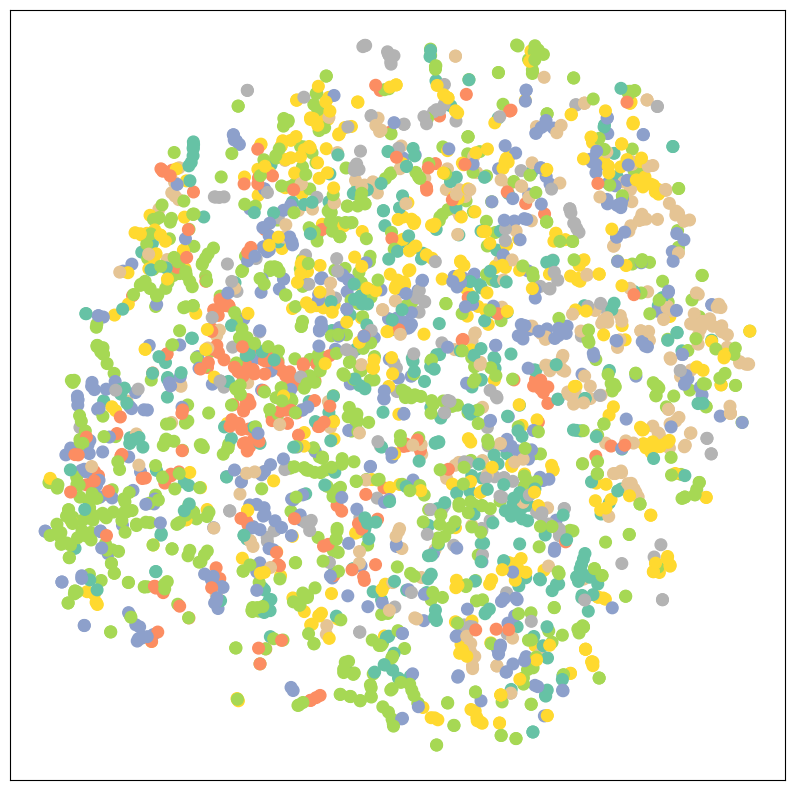

In [ ]:
#trực quan hóa mô hình trước khi huấn luyện
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)


In [ ]:
#Training GNN
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc


val_acc_all = []
test_acc_all = []
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9463, Val: 0.2880, Test: 0.2700
Epoch: 002, Loss: 1.9409, Val: 0.2580, Test: 0.2910
Epoch: 003, Loss: 1.9343, Val: 0.2560, Test: 0.2910
Epoch: 004, Loss: 1.9275, Val: 0.2640, Test: 0.3210
Epoch: 005, Loss: 1.9181, Val: 0.3220, Test: 0.3630
Epoch: 006, Loss: 1.9086, Val: 0.4000, Test: 0.4120
Epoch: 007, Loss: 1.9015, Val: 0.3900, Test: 0.4010
Epoch: 008, Loss: 1.8933, Val: 0.3900, Test: 0.4020
Epoch: 009, Loss: 1.8808, Val: 0.4220, Test: 0.4180
Epoch: 010, Loss: 1.8685, Val: 0.4560, Test: 0.4470
Epoch: 011, Loss: 1.8598, Val: 0.4760, Test: 0.4680
Epoch: 012, Loss: 1.8482, Val: 0.5120, Test: 0.5180
Epoch: 013, Loss: 1.8290, Val: 0.5380, Test: 0.5440
Epoch: 014, Loss: 1.8233, Val: 0.5580, Test: 0.5720
Epoch: 015, Loss: 1.8057, Val: 0.5820, Test: 0.5910
Epoch: 016, Loss: 1.7966, Val: 0.6060, Test: 0.6080
Epoch: 017, Loss: 1.7825, Val: 0.6200, Test: 0.6300
Epoch: 018, Loss: 1.7617, Val: 0.6280, Test: 0.6450
Epoch: 019, Loss: 1.7491, Val: 0.6280, Test: 0.6520
Epoch: 020, 

In [ ]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


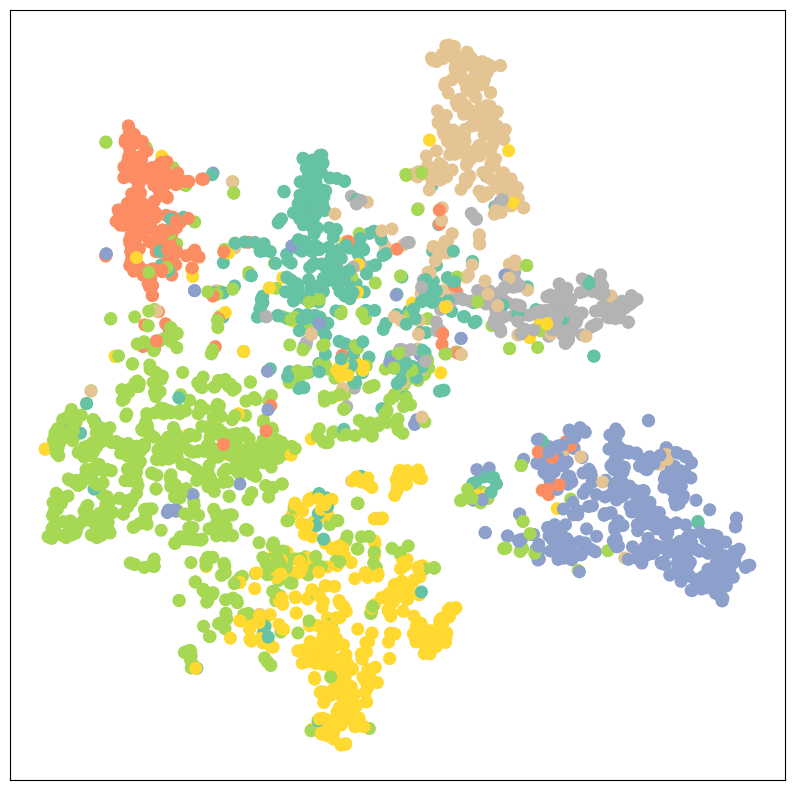

In [ ]:
#trực quan hóa mô hình sau training
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)


# Sử dụng GCN để dự đoán liên kết


In [ ]:
# thử nghiệm với dataset florentine_families_graph()
import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import from_networkx

# 1. Tải Les Miserables Network từ NetworkX và chuyển sang PyTorch Geometric
G = nx.les_miserables_graph()
data = from_networkx(G)

# Thêm đặc trưng node giả định: dùng ma trận đơn vị (identity matrix)
data.x = torch.eye(data.num_nodes)
data.y = torch.randint(0, 2, (data.num_nodes,))  # Gán nhãn ngẫu nhiên (giả định 2 lớp)

# In thông tin đồ thị
print("Florentine Families Graph:")
print("==========================")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node features shape: {data.x.shape}")
print(f"Labels shape: {data.y.shape}")
print(data)


Florentine Families Graph:
Number of nodes: 77
Number of edges: 508
Node features shape: torch.Size([77, 77])
Labels shape: torch.Size([77])
Data(edge_index=[2, 508], weight=[508], num_nodes=77, x=[77, 77], y=[77])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx, train_test_split_edges, negative_sampling
import networkx as nx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Load Les Miserables Graph
G = nx.les_miserables_graph()
data = from_networkx(G)
data.x = torch.eye(data.num_nodes)  # Đặc trưng node đơn giản (ma trận đơn vị)
data = train_test_split_edges(data)  # Chia tập huấn luyện và kiểm tra

# 2. Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.x.size(1), hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 3. Metrics Function
def compute_metrics(pos_pred, neg_pred):
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0).cpu()
    y_pred = torch.cat([pos_pred, neg_pred], dim=0).cpu()
    y_pred_binary = (y_pred > 0.0).float()

    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, auc

# 4. Train Function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.train_pos_edge_index)

    # Generate negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
        method='sparse'
    )

    # Positive loss
    pos_loss = -torch.log(
        torch.sigmoid((z[data.train_pos_edge_index[0]] * z[data.train_pos_edge_index[1]]).sum(dim=1))
    ).mean()

    # Negative loss
    neg_loss = -torch.log(
        torch.sigmoid(-(z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1))
    ).mean()

    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss

# 5. Link Prediction Function
def link_prediction(model, data):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.train_pos_edge_index)
        pos_pred = (z[data.test_pos_edge_index[0]] * z[data.test_pos_edge_index[1]]).sum(dim=1)
        neg_pred = (z[data.test_neg_edge_index[0]] * z[data.test_neg_edge_index[1]]).sum(dim=1)
    return pos_pred, neg_pred

# 6. Training Loop with Metrics
for epoch in range(1, 201):
    loss = train()

    # Compute validation/test metrics
    pos_pred, neg_pred = link_prediction(model, data)
    acc, precision, recall, f1, auc = compute_metrics(pos_pred, neg_pred)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Epoch: 020, Loss: 1.0465, Accuracy: 0.7000, Precision: 0.6389, Recall: 0.9200, F1: 0.7541, AUC: 0.8240
Epoch: 040, Loss: 1.0031, Accuracy: 0.7200, Precision: 0.6667, Recall: 0.8800, F1: 0.7586, AUC: 0.8384
Epoch: 060, Loss: 0.8805, Accuracy: 0.6800, Precision: 0.6364, Recall: 0.8400, F1: 0.7241, AUC: 0.8480
Epoch: 080, Loss: 0.8798, Accuracy: 0.7200, Precision: 0.6774, Recall: 0.8400, F1: 0.7500, AUC: 0.8352
Epoch: 100, Loss: 0.8992, Accuracy: 0.7000, Precision: 0.6562, Recall: 0.8400, F1: 0.7368, AUC: 0.8480
Epoch: 120, Loss: 0.9097, Accuracy: 0.7000, Precision: 0.6562, Recall: 0.8400, F1: 0.7368, AUC: 0.8624
Epoch: 140, Loss: 0.8444, Accuracy: 0.7200, Precision: 0.6774, Recall: 0.8400, F1: 0.7500, AUC: 0.8512
Epoch: 160, Loss: 0.8516, Accuracy: 0.7800, Precision: 0.7333, Recall: 0.8800, F1: 0.8000, AUC: 0.8640
Epoch: 180, Loss: 0.8340, Accuracy: 0.7600, Precision: 0.7097, Recall: 0.8800, F1: 0.7857, AUC: 0.8656
Epoch: 200, Loss: 0.8391, Accuracy: 0.7200, Precision: 0.6667, Recall: 0.

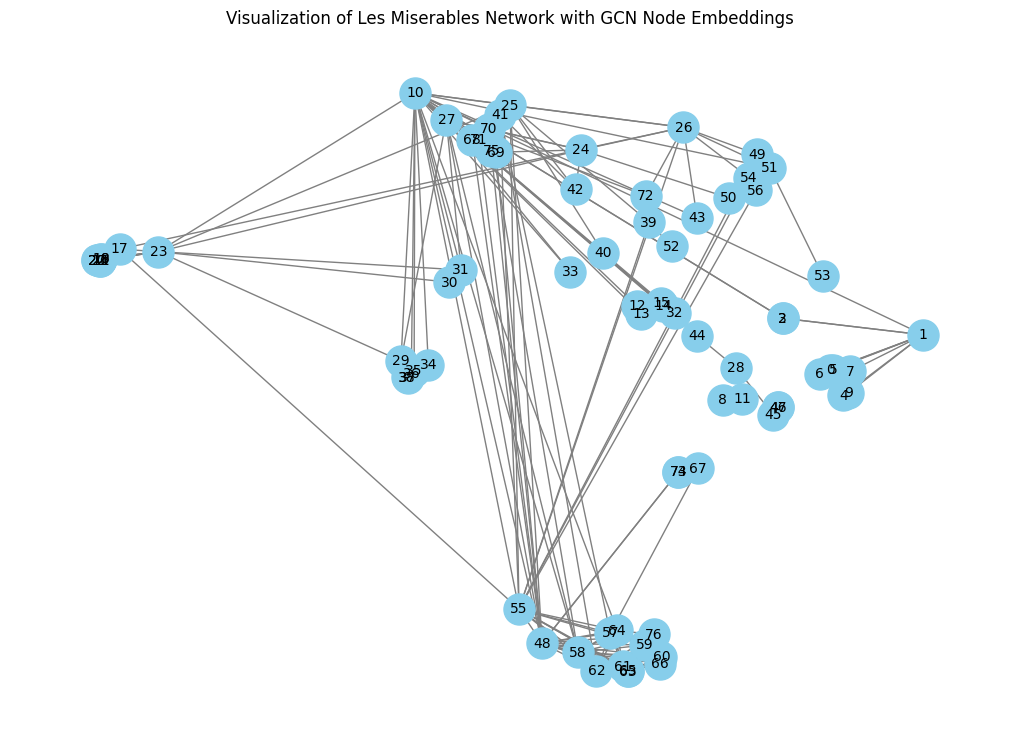

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.utils import to_networkx

# Tạo edge_index tạm thời bằng train_pos_edge_index
data.edge_index = data.train_pos_edge_index

# 1. Lấy nhúng node từ mô hình GCN
model.eval()
with torch.no_grad():
    z = model(data.x, data.train_pos_edge_index).cpu().numpy()

# 2. Giảm chiều nhúng node bằng t-SNE
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

# 3. Chuyển đồ thị sang dạng NetworkX để vẽ
G_nx = to_networkx(data, to_undirected=True)
pos = {i: z_2d[i] for i in range(data.num_nodes)}  # Tọa độ của các node từ t-SNE

# 4. Vẽ đồ thị với nhúng 2D
plt.figure(figsize=(10, 7))
nx.draw(G_nx, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
plt.title("Visualization of Les Miserables Network with GCN Node Embeddings")
plt.show()


Nhận xét chung:

Kết quả so sánh giữa GCN và các phương pháp khác cho thấy mỗi phương pháp đều có những ưu điểm riêng, tùy thuộc vào cách đánh giá. GCN thể hiện hiệu suất tương đối tốt, đặc biệt là ở Recall (0.8800), cho thấy khả năng phát hiện đúng các mẫu tích cực cao. Tuy nhiên, các chỉ số khác như Accuracy (0.7200), Precision (0.6667), và F1-score (0.7586) của GCN lại thấp hơn so với các phương pháp dựa trên đặc trưng đồ thị như Common Neighbors, Jaccard Coefficient, và Adamic-Adar.